### 머신 러닝

- 어떤 알고리즘을 사용할 것인가를 판단하기 위해서는 사전 분석을 잘하는 것이 중요합니다.

### 고객의 전체 모습을 파악

- 머신러닝을 하기 위한 데이터 가공 기술을 배우면서 고객 행동을 분석하고 파악

고객의 소리) 
제가 운영하는 스포츠 센터는 트레이닝 붐 덕분에 지금까지 고객 수가 늘었습니다. 그런데 최근 1년간 고객 수가 늘지 않는 것 같습니다. 자주 이용하는 고객은 계속 오지만 가끔 오는 고객은 어느새 오지 않는 경우도 생기는 것 같습니다. 제대로 데이터 분석한 적이 없어서 어떤 고객이 계속 이용하고 있는지조차 모릅니다.             

전제 조건)                
회원 구분 : 종일 회원(센터를 언제든 사용 가능), 주간 회원(낮에만 사용 가능), 야간 회원(밤에만 사용 가능)           
입회비 : 비정기적으로 입회비 반액 할인 / 입회비 무료 행사를 해서 신규 회원을 늘림                 
탈퇴 : 월말까지 신청하면 그 다음 달 말에 탈퇴                     

데이터셋)          
1. use_log.csv : 센터 이용 이력(회원이 센터를 이용하면 시스템에 자동 입력 - 2018년 4월 ~ 2019년 3월의 1년분 데이터)     
2. customer_master.csv : 2019년 3월 말 시점의 회원 데이터(이전에 탈퇴한 회원 포함 - 전체 기간)             
3. class_master.csv : 회원 구분 데이터(종일, 주간, 야간)           
4. campaign_master.csv : 가입 시 행사 종류 데이터(입회비 유무 등)               

** 
현재 시점 : 2019년 3월 말

최근 1년 회원(start_date) : x >= pd.to_datetime('20180401')               
최근 1개월 회원(end_date) : x >= pd.to_datetime('20190331') | x.isnull()                 
-> 20190331은 2월에 신청하고 3월에 퇴원처리로 3월 중에는 회원           
-> 20190331의 is_deleted열은 '1'로 입력되어 있음

회원 기간(end_date) : end_date의 nan데이터에 '20190430' 대입             
-> 3월 중 탈퇴 신청하지 않아 0430까지는 '무조건' 회원


end_date가 없는 경우 > 3월까지 탈퇴 신청 X(4월까지는 회원) > 회원 기간 04.30 _ start_date

In [1]:
import pandas as pd 
import numpy as np 

In [2]:
use_log_df = pd.read_csv('./data/1장/use_log.csv') # 이용 기록
len(use_log_df) # 197,428
use_log_df.head()

log_id customer_id     usedate
0  L00000049012330    AS009373  2018-04-01
1  L00000049012331    AS015315  2018-04-01
2  L00000049012332    AS040841  2018-04-01
3  L00000049012333    AS046594  2018-04-01
4  L00000049012334    AS073285  2018-04-01

In [3]:
customer_master_df = pd.read_csv('./data/1장/customer_master.csv') # 고객 데이터
len(customer_master_df) # 4192
customer_master_df

# is_deleted : 201903 시점에 이미 탈퇴한 유저를 시스템에서 빨리 찾기 위한 칼럼
# 회원 데이터는 4,192명으로 이미 탈퇴한 유저도 포함되어 있음
# 3월말에 신청해서 4월에 탈퇴하는 경우 end_date : 0430 & is_delected : 0

customer_id   name class gender           start_date end_date  \
0       OA832399   XXXX   C01      F  2015-05-01 00:00:00      NaN   
1       PL270116  XXXXX   C01      M  2015-05-01 00:00:00      NaN   
2       OA974876  XXXXX   C01      M  2015-05-01 00:00:00      NaN   
3       HD024127  XXXXX   C01      F  2015-05-01 00:00:00      NaN   
4       HD661448  XXXXX   C03      F  2015-05-01 00:00:00      NaN   
...          ...    ...   ...    ...                  ...      ...   
4187    HD676663   XXXX   C01      M  2019-03-14 00:00:00      NaN   
4188    HD246549  XXXXX   C01      F  2019-03-14 00:00:00      NaN   
4189    GD037007  XXXXX   C03      M  2019-03-14 00:00:00      NaN   
4190    OA953150  XXXXX   C01      M  2019-03-14 00:00:00      NaN   
4191    IK692635  XXXXX   C02      F  2019-03-15 00:00:00      NaN   

     campaign_id  is_deleted  
0            CA1           0  
1            CA1           0  
2            CA1           0  
3            CA1           0  
4            CA1           0  
...          ...         ...  
4187         CA1           0  
4188         CA1           0  
4189         CA1           0  
4190         CA1           0  
4191         CA1           0  

[4192 rows x 8 columns]

In [4]:
class_master_df = pd.read_csv('./data/1장/class_master.csv') # 고객 구분(종일/주간/야간)
len(class_master_df) # 3
class_master_df.head()

class class_name  price
0   C01       0_종일  10500
1   C02       1_주간   7500
2   C03       2_야간   6000

In [5]:
campaign_master_df = pd.read_csv('./data/1장/campaign_master.csv') # 고객 구분(종일/주간/야간)
len(campaign_master_df) # 3
campaign_master_df.head()

campaign_id campaign_name
0         CA1          2_일반
1         CA2     0_입회비반액할인
2         CA3       1_입회비무료

- customer_master의 customer_id + use_log의 customer_id
- customer_master의 class + class_master의 class
- customer_master의 campaign_id + campaign_master의 campaign_id              
-> 결합 가능

>> 분석의 목적이 되는 기준 데이터

이 장의 경우 가능한 것은 고객 데이터인 custeomer_master와 이용 이력 데이터인 use_log입니다.

먼저, 데이터 수가 적은 고객 데이터(customer_master)를 메인으로 진행             
후반에서는 이용 이력 데이터(use_log)를 중심으로 분석도 진행 예정             
일단 이용 이력 데이터는 무시하고, 고객 데이터를 수정해서 <B><U>어떤 고객이 몇 명이었는지</U></B>와 같은 전체 모습을 파악

In [6]:
customer_class_df = pd.merge(left= customer_master_df, right= class_master_df,
                             how= 'left', left_on= 'class', right_on= 'class')
customer_class_df 


customer_merge_df = pd.merge(left= customer_class_df, right= campaign_master_df, how= 'left',
                             on= 'campaign_id')
customer_merge_df # 회원수 4192 그대로 열 3개 추가

# column명 동일하면 left_on, right_on 대신 on 사용
# left_on, right_on 사용하는 경우 두 열 모두 df에 포함되므로 둘 중 한 열은 삭제


customer_id   name class gender           start_date end_date  \
0       OA832399   XXXX   C01      F  2015-05-01 00:00:00      NaN   
1       PL270116  XXXXX   C01      M  2015-05-01 00:00:00      NaN   
2       OA974876  XXXXX   C01      M  2015-05-01 00:00:00      NaN   
3       HD024127  XXXXX   C01      F  2015-05-01 00:00:00      NaN   
4       HD661448  XXXXX   C03      F  2015-05-01 00:00:00      NaN   
...          ...    ...   ...    ...                  ...      ...   
4187    HD676663   XXXX   C01      M  2019-03-14 00:00:00      NaN   
4188    HD246549  XXXXX   C01      F  2019-03-14 00:00:00      NaN   
4189    GD037007  XXXXX   C03      M  2019-03-14 00:00:00      NaN   
4190    OA953150  XXXXX   C01      M  2019-03-14 00:00:00      NaN   
4191    IK692635  XXXXX   C02      F  2019-03-15 00:00:00      NaN   

     campaign_id  is_deleted class_name  price campaign_name  
0            CA1           0       0_종일  10500          2_일반  
1            CA1           0       0_종일  10500          2_일반  
2            CA1           0       0_종일  10500          2_일반  
3            CA1           0       0_종일  10500          2_일반  
4            CA1           0       2_야간   6000          2_일반  
...          ...         ...        ...    ...           ...  
4187         CA1           0       0_종일  10500          2_일반  
4188         CA1           0       0_종일  10500          2_일반  
4189         CA1           0       2_야간   6000          2_일반  
4190         CA1           0       0_종일  10500          2_일반  
4191         CA1           0       1_주간   7500          2_일반  

[4192 rows x 11 columns]

>> 조인 후 결측치 확인

In [7]:
# 조인할 때 키가 없거나 잘못 조인되면 자동으로 결측치가 들어감 > 확인 필요
customer_merge_df.isnull().sum(axis= 0)
customer_merge_df.isnull().sum()

# end_date 외에는 결측치가 0으로, 
# 이번 조인에서 추가한 class_name, price, campaign_name에는 데이터가 정확하게 들어 있는 것을 확인

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

>> 고객 데이터 집계

- 고객 데이터 집계를 통해 고객 전체 모습을 확인
1. 어떤 회원과 어떤 캠페인이 많은지
2. 언제 입회/탈퇴가 많은지
3. 남녀 비율은 얼마인지
4. 탈퇴할 때까지의 기간은 어느 정도인지

In [8]:
# 회원 class 구분, 캠페인 구분, 성별, 탈퇴 여부 집계
customer_merge_df.groupby(by= 'class_name')['customer_id'].count() # 종일 : 2045, 주간 : 1019, 야간 : 1128

customer_merge_df.groupby(by= 'campaign_name')['customer_id'].count() # 반액 : 650, 무료 : 492, 일반 : 3050

customer_merge_df.groupby(by= 'gender')['customer_id'].count() # 여성 : 1983, 남성 : 2209

customer_merge_df.groupby(by= 'is_deleted')['customer_id'].count() # 고객 : 2842, 탈퇴 : 1350

# 회원 클래스 종일(절반) > 야간 > 주간
# 캠페인 구분 : 일반 입회 > 캠페인 입회 & 캠페인 입회에 의한 가입이 약 20%
# 남자 > 여자 (근소한 차이)
# 2019년 03월 기준) 가입 회원 : 2842명, 탈퇴 회원 : 1350명

# >> 캠페인이 시작된 시기, 성별과 회원 클래스의 관계, 올해 가입 인원 등 궁금증 발생
# 이는 집계해서 확인하기보다 현장 사람들이 아는 경우가 많음

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [9]:
# start_date가 2018년 4월 1일 이후부터 2019년 03월 31일까지 가입 인원 집계

# str, float 구분 필요 x
customer_merge_df['start_date'] = pd.to_datetime(customer_merge_df['start_date'])

customer_merge_df['start_date'] # datetime

0      2015-05-01
1      2015-05-01
2      2015-05-01
3      2015-05-01
4      2015-05-01
          ...    
4187   2019-03-14
4188   2019-03-14
4189   2019-03-14
4190   2019-03-14
4191   2019-03-15
Name: start_date, Length: 4192, dtype: datetime64[ns]

In [10]:
customer_merge_df.loc[(customer_merge_df['start_date'] > '2018-04-01')
                      & (customer_merge_df['start_date'] < '2019-03-31'),
                      'customer_id'].count()

# 책)
lately_1year_customer = customer_merge_df.loc[(customer_merge_df['start_date'] > pd.to_datetime('20180401')),
                      'customer_id']
print(len(lately_1year_customer))

# 해당 기간 동안의 가입 인원 : 1361

1361


>> 최근 고객 정보(3월 '유지' 회원)

- <u>가장 최근 월(2019년 3월)에 회원인 고객</u> 데이터 파악           
현재 고객 데이터에서는 이미 탈퇴한 고객도 포함되어 있어 월별 집계와는 차이가 있습니다.             
<u>가장 최근 월의 고객 데이터를 집계해서 현재 고객의 전체 모습을 파악</u>

1) 2019년 3월(2019년 3월 31일)에 탈퇴한 고객과 재적 중인 고객을 추출
2) is_deleted 열로 추출

** 2)의 경우 2019년 3월에 탈퇴한 고객은 카운트되지 않기 때문에 주의

In [11]:
customer_merge_df['end_date'] = pd.to_datetime(customer_merge_df['end_date'])
customer_merge_df['end_date']

0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
        ..
4187   NaT
4188   NaT
4189   NaT
4190   NaT
4191   NaT
Name: end_date, Length: 4192, dtype: datetime64[ns]

In [12]:
# 방법 1)

# >= 20190331 : 전달에 탈퇴 신청한 고객 0331에 탈퇴 '처리'되기 때문
# end_date가 0331면 2월 중 이미 탈퇴 신청 후 탈퇴 고객임
lately_1month_customer = customer_merge_df.loc[(customer_merge_df['end_date'] >= pd.to_datetime('20190331'))
                                               | customer_merge_df['end_date'].isnull()]

print((len(lately_1month_customer))) # 2953명
lately_1month_customer
lately_1month_customer['end_date'].unique() # NaT, '2019-03-31' : 3월에 탈퇴하지 않은 고객

2953


<DatetimeArray>
['NaT', '2019-03-31 00:00:00']
Length: 2, dtype: datetime64[ns]

>> 전체 집계 결과와의 비교

In [13]:
# 회원 class 구분, 캠페인 구분, 성별, 탈퇴 여부 집계 - 4192
customer_merge_df.groupby(by= 'class_name')['customer_id'].count() # 종일 : 2045, 주간 : 1019, 야간 : 1128
# 전체 회원 중 종일권 비율 : 48.8%

customer_merge_df.groupby(by= 'campaign_name')['customer_id'].count() # 반액 : 650, 무료 : 492, 일반 : 3050
# 전체 회원 중 일반으로 가입한 비율 : 72%

customer_merge_df.groupby(by= 'gender')['customer_id'].count() # 여성 : 1983, 남성 : 2209
# 전체 회원 중 여성 회원 비율 : 47.3%


gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [14]:
# 3월 유지 회원으로 전체 파악 
# 회원 구분(class), 캠페인 구분, 성별 집계 - 2953

lately_1month_customer.groupby(by= 'class_name')['customer_id'].count() # 종일 : 1444, 주간 : 696, 야간 : 813
# 유지 회원 중 종일권 비율 : 48.9%

lately_1month_customer.groupby(by= 'campaign_name')['customer_id'].count() # 반액 : 311, 무료 : 242, 일반 : 2400
# 전체 회원 중 일반으로 가입한 비율 : 81%
# : 입회 캠페인은 회원 비율 변화에 영향을 미친다고 추측할 수 있습니다.
# : 유지한 회원이 일반으로 가입한 경우가 많음

lately_1month_customer.groupby(by= 'gender')['customer_id'].count() # 여성 : 1400, 남성 : 1553
# 유지 회원 중 여성 회원 비율 : 47.41%

gender
F    1400
M    1553
Name: customer_id, dtype: int64

>> 이용 이력 데이터 활용(use_log_df)

- 이용 이력 데이터는 고객 데이터와는 달리 시간적인 요소를 분석할 수 있습니다.                

1. 한 달 이용 횟수의 변화
2. 회원의 (비)정기적인 이용 여부

>> 월 이용 횟수 분석

In [15]:
use_log_df

log_id customer_id     usedate
0       L00000049012330    AS009373  2018-04-01
1       L00000049012331    AS015315  2018-04-01
2       L00000049012332    AS040841  2018-04-01
3       L00000049012333    AS046594  2018-04-01
4       L00000049012334    AS073285  2018-04-01
...                 ...         ...         ...
197423  L00000049209753    TS977703  2019-03-31
197424  L00000049209754    TS979550  2019-03-31
197425  L00000049209755    TS995299  2019-03-31
197426  L00000049209756    TS995853  2019-03-31
197427  L00000049209757    TS999079  2019-03-31

[197428 rows x 3 columns]

In [16]:
# 고객별 월 이용 횟수

use_log_df['usedate'] = pd.to_datetime(use_log_df['usedate'])
use_log_df['usedate']

use_log_df['use_month'] = use_log_df['usedate'].dt.strftime('%Y%m')
use_log_df['use_month']

# 실습)
monthly_use_log_df = pd.pivot_table(data= use_log_df, index= 'customer_id', columns= 'use_month',
                                    aggfunc= 'count')
monthly_use_log_df

# 책)
monthly_use_log_df = use_log_df.groupby(['use_month', 'customer_id'], as_index= False).count()
# as_index = False > use_month를 묶어서 index로 사용하는 것을 하지 않음
monthly_use_log_df
# use_month, customer_id를 기준으로 log_id, use_date에 값이 있으면 count()

monthly_use_log_df.rename(columns= {'log_id' : 'use_count'}, inplace= True)
monthly_use_log_df

monthly_use_log_df.drop('usedate', inplace=  True, axis= 1)
monthly_use_log_df

# 고객 AS002855	: 2018년 4월에 '4'회 이용

use_month customer_id  use_count
0        201804    AS002855          4
1        201804    AS009013          2
2        201804    AS009373          3
3        201804    AS015315          6
4        201804    AS015739          7
...         ...         ...        ...
36837    201903    TS995853          8
36838    201903    TS998593          8
36839    201903    TS999079          3
36840    201903    TS999231          6
36841    201903    TS999855          4

[36842 rows x 3 columns]

>> 고객별 평균값, 중앙값, 최댓값, 최솟값 집계

In [17]:
monthly_use_stats = monthly_use_log_df.groupby(by= 'customer_id')['use_count'].agg(['mean', 'median', 'max', 'min'])
monthly_use_stats = monthly_use_stats.reset_index(drop= False) 
# groupby의 영향으로 customer_id가 index에 들어가 있기 때문에 이를 컬럼으로 변경
# drop= False : 인덱스를 컬럼으로 유지하면서, 정수형 기본 인덱스를 다시 생성
# drop= True : 인덱스를 완전히 제거(컬럼으로 남기지 않음)
monthly_use_stats.head()

# 고객 AS002855 | 평균값 4.5 / 중앙값 5 / 최댓값 7 / 최솟값 2

customer_id      mean  median  max  min
0    AS002855  4.500000     5.0    7    2
1    AS008805  4.000000     4.0    8    1
2    AS009013  2.000000     2.0    2    2
3    AS009373  5.083333     5.0    7    3
4    AS015233  7.545455     7.0   11    4

>> 정기적 / 비정기적 스포츠 센터 이용 여부

- 정기 이용 플래그

스포츠 센터의 경우 <b><u>지속 요소</u></b> 중 하나로 <b><u>'습관'</u></b>을 생각할 수 있습니다. 여기서는 정기적으로 센터를 이용하는 고객을 특정해 봅시다. <u>정기적이라는 것은 정의</u>하는 방법에 따라 다르지만, 여기서는 <u>매주 같은 요일에 왔는지</u> 아닌지로 판단하겠습니다.                  

>> 고객별 월/요일별로 집계

최댓값이 4 이상인 요일이 하나라도 있는 회원은 플래그를 1로 처리            
<-> 한 주에 한 요일이라도 4회 이상인 회원

In [18]:
# use_log_df['usedate'] # datetime
use_log_df['use_weekday'] = use_log_df['usedate'].dt.weekday
use_log_df['use_weekday'] # 0 : 월요일 ~ 6 : 일요일

monthly_weekly_use_df = use_log_df.groupby(by= ['customer_id', 'use_month', 'use_weekday'], as_index= False).count()[['customer_id', 'use_month', 'use_weekday', 'log_id']] # 원하는 열만 선택
monthly_weekly_use_df

monthly_weekly_use_df.rename(columns= {'log_id' : 'use_count'}, inplace= True)
# monthly_weekly_use_df.drop(labels= 'usedate', axis= 1, inplace= True) # 원하는 열만 선택하면 삭제할 필요 x
monthly_weekly_use_df

# 회원 AS002855은 2018년 4월 weekday 5에도 4번, 2018년 5월 weekday 5(토)에도 4번 > 매주 토요일에 방문

customer_id use_month  use_weekday  use_count
0        AS002855    201804            5          4
1        AS002855    201805            2          1
2        AS002855    201805            5          4
3        AS002855    201806            5          5
4        AS002855    201807            1          1
...           ...       ...          ...        ...
93328    TS999855    201901            1          1
93329    TS999855    201901            5          4
93330    TS999855    201901            6          1
93331    TS999855    201902            5          4
93332    TS999855    201903            5          4

[93333 rows x 4 columns]

>> 고객별 최댓값 계산        

그 최댓값이 4 이상일 경우 플래그 지정

In [19]:
# 특정 월, 특정 요일의 방문 집계 중 가장 많이 이용한 횟수(max값)
# 이 횟수가 4 이상인 사람은 적어도 어떤 달의 매주 특정 요일에 정기적으로 방문한 고객

monthly_weekly_use_df

# 1)
user_count_max = monthly_weekly_use_df.groupby(by= 'customer_id', as_index= False)['use_count'].max()
# : customer_id별로 use_count가 max인 값을 집계 > customer_id, use_count열만 반환

# 2) 
use_count_max = monthly_weekly_use_df.groupby(by= ['customer_id'], as_index= False).max()[['customer_id', 'use_count']]
# : customer_id별로 모든 열의 max값을 집계 후 > customer_id, use_count열만 반환

# 참고)
x_use_count_max = monthly_weekly_use_df.groupby(by= 'customer_id').max() # use_month, use_weekday도 max값으로 가져와짐


regular_user_df = user_count_max.copy()
regular_user_df['regularity'] = np.where(user_count_max['use_count'] < 4, 0, 1)
regular_user_df


customer_id  use_count  regularity
0       AS002855          5           1
1       AS008805          4           1
2       AS009013          2           0
3       AS009373          5           1
4       AS015233          5           1
...          ...        ...         ...
4187    TS995853          5           1
4188    TS998593          5           1
4189    TS999079          5           1
4190    TS999231          5           1
4191    TS999855          5           1

[4192 rows x 3 columns]

In [20]:
# 참고)
# use_count가 가장 클 때의 weekday / month를 알고 싶다면!
max_idx = monthly_weekly_use_df.groupby('customer_id')['use_count'].idxmax()  # use_count가 max일 때의 idx
use_count_max_info = monthly_weekly_use_df.loc[max_idx]
use_count_max_info

# - 실습
max_user_idx = monthly_weekly_use_df.groupby(by= 'customer_id')['use_count'].idxmax() # customer_id별로 use_count가 최대인 값을 집계한 인덱스
max_regular_user_info = monthly_weekly_use_df.loc[max_user_idx]
print(max_user_idx) # series 열 : customer_id, 값 : idx
max_regular_user_info

x_max_user_idx = monthly_weekly_use_df.groupby(by= 'customer_id', as_index= False)['use_count'].max().index # customer_id를 기준으로 다른 열 최댓값 중 use_count열만 가져옴
# - 새로운 데이터프레임의 인덱스를 가져오게 됨

customer_id
AS002855        3
AS008805       28
AS009013       50
AS009373       55
AS015233       94
            ...  
TS995853    93238
TS998593    93242
TS999079    93267
TS999231    93300
TS999855    93320
Name: use_count, Length: 4192, dtype: int64


>> 고객 데이터와 결합

monthly_use_stats(=df) : 월별 고객 통계치(평균,중앙값,최댓값,최솟값)           
regular_user_df : 고객별 최대 방문수(regularity열 포함)              

customer_merge_df : 고객 데이터(class_master, campaign_master 결합한 DataFrame)

In [21]:
# use_count는 max값

total_customer_df = pd.merge(left= customer_merge_df, right= monthly_use_stats,
                             how= 'left', on= 'customer_id')
total_customer_df

total_customer_df = pd.merge(left= total_customer_df, right= regular_user_df[['customer_id', 'regularity']],
                             how= 'left', on= 'customer_id')
total_customer_df

customer_id   name class gender start_date end_date campaign_id  \
0       OA832399   XXXX   C01      F 2015-05-01      NaT         CA1   
1       PL270116  XXXXX   C01      M 2015-05-01      NaT         CA1   
2       OA974876  XXXXX   C01      M 2015-05-01      NaT         CA1   
3       HD024127  XXXXX   C01      F 2015-05-01      NaT         CA1   
4       HD661448  XXXXX   C03      F 2015-05-01      NaT         CA1   
...          ...    ...   ...    ...        ...      ...         ...   
4187    HD676663   XXXX   C01      M 2019-03-14      NaT         CA1   
4188    HD246549  XXXXX   C01      F 2019-03-14      NaT         CA1   
4189    GD037007  XXXXX   C03      M 2019-03-14      NaT         CA1   
4190    OA953150  XXXXX   C01      M 2019-03-14      NaT         CA1   
4191    IK692635  XXXXX   C02      F 2019-03-15      NaT         CA1   

      is_deleted class_name  price campaign_name       mean  median  max  min  \
0              0       0_종일  10500          2_일반   4.833333     5.0    8    2   
1              0       0_종일  10500          2_일반   5.083333     5.0    7    3   
2              0       0_종일  10500          2_일반   4.583333     5.0    6    3   
3              0       0_종일  10500          2_일반   4.833333     4.5    7    2   
4              0       2_야간   6000          2_일반   3.916667     4.0    6    1   
...          ...        ...    ...           ...        ...     ...  ...  ...   
4187           0       0_종일  10500          2_일반   8.000000     8.0    8    8   
4188           0       0_종일  10500          2_일반  10.000000    10.0   10   10   
4189           0       2_야간   6000          2_일반   8.000000     8.0    8    8   
4190           0       0_종일  10500          2_일반  11.000000    11.0   11   11   
4191           0       1_주간   7500          2_일반  10.000000    10.0   10   10   

      regularity  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
4187           0  
4188           0  
4189           0  
4190           0  
4191           0  

[4192 rows x 16 columns]

In [22]:
# 결측치 확인

total_customer_df.isnull().sum()


customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
regularity          0
dtype: int64

--> 고객 데이터 + 이용 이력 데이터 > 시간적인 변화 데이터를 추가

>> 회원 기간 컬럼 추가

In [23]:
# 월 단위 집계
# 탈퇴하지 않은 회원을 2019-04-30으로 채워서 계산
# 2019-03-31으로 하는 경우 2월에 탈퇴 신청을 한 사람과 구분 불가능(2019-03-31에 퇴원 처리)

# 
total_customer_df['calc_date'] = total_customer_df['end_date'].fillna(pd.to_datetime('20190430'))
total_customer_df['membership_period'] = (total_customer_df['calc_date'].dt.year - total_customer_df['start_date'].dt.year) * 12 + (total_customer_df['calc_date'].dt.month - total_customer_df['start_date'].dt.month)

total_customer_df['membership_period']

# 책)
from dateutil.relativedelta import relativedelta

total_customer_df['calc_date'] = total_customer_df['end_date'].fillna(pd.to_datetime('20190430'))
total_customer_df['membership_period'] = 0

for i in range(len(total_customer_df)) :
  delta = relativedelta(total_customer_df['calc_date'].iloc[i], total_customer_df['start_date'].iloc[i])
  total_customer_df['membership_period'].iloc[i] = delta.years*12 + delta.months


total_customer_df.head()


C:\Users\LGCARE\AppData\Local\Temp\ipykernel_23288\1600362293.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  total_customer_df['membership_period'].iloc[i] = delta.years*12 + delta.months
C:\Users\LGCARE\AppData\Local\Temp\ipykernel_23

customer_id   name class gender start_date end_date campaign_id  is_deleted  \
0    OA832399   XXXX   C01      F 2015-05-01      NaT         CA1           0   
1    PL270116  XXXXX   C01      M 2015-05-01      NaT         CA1           0   
2    OA974876  XXXXX   C01      M 2015-05-01      NaT         CA1           0   
3    HD024127  XXXXX   C01      F 2015-05-01      NaT         CA1           0   
4    HD661448  XXXXX   C03      F 2015-05-01      NaT         CA1           0   

  class_name  price campaign_name      mean  median  max  min  regularity  \
0       0_종일  10500          2_일반  4.833333     5.0    8    2           1   
1       0_종일  10500          2_일반  5.083333     5.0    7    3           1   
2       0_종일  10500          2_일반  4.583333     5.0    6    3           1   
3       0_종일  10500          2_일반  4.833333     4.5    7    2           1   
4       2_야간   6000          2_일반  3.916667     4.0    6    1           1   

   calc_date  membership_period  
0 2019-04-30                 47  
1 2019-04-30                 47  
2 2019-04-30                 47  
3 2019-04-30                 47  
4 2019-04-30                 47

>> 고객 행동의 각종 통계량 파악

In [ ]:
total_customer_df[['mean', 'median', 'min', 'max']].describe() # 회원 전체의 사용 횟수 평균/중앙값/최솟값/최댓값
# 회원 중 최소로 1회 이용 고객, 최대 14회 이용 고객 o
# 회원 평균적으로 5.3회 정도 이용

# 주의)
# total_customer_df의 컬럼 'mean' : 각 고객의 매월 평균 이용 횟수
# describe_df 행의 'mean' : 고객의 매월 평균 이용 횟수의 평균


mean       median          min          max
count  4192.000000  4192.000000  4192.000000  4192.000000
mean      5.333127     5.250596     3.041269     7.823950
std       1.777533     1.874874     1.951565     2.168959
min       1.000000     1.000000     1.000000     1.000000
25%       4.250000     4.000000     2.000000     7.000000
50%       5.000000     5.000000     3.000000     8.000000
75%       6.416667     6.500000     4.000000     9.000000
max      12.000000    12.000000    12.000000    14.000000

In [28]:
total_customer_df.groupby(by= 'regularity').count()['customer_id']

# 0 : 779
# 1 : 3413
# > 정기적으로 이용하는 회원이 많음

regularity
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

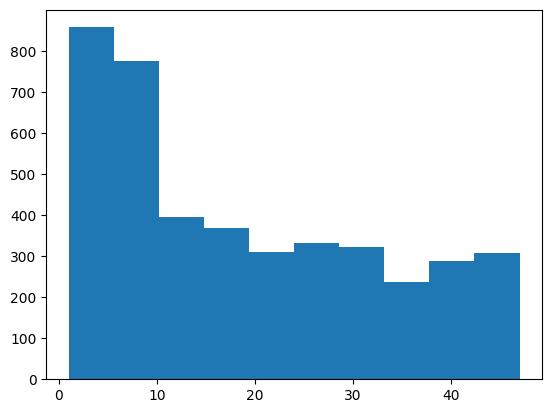

In [ ]:
# 회원 기간의 분포
import matplotlib.pyplot as plt

# x : membership_period, y : 빈도수(count)
plt.hist(x= total_customer_df['membership_period'])

# 회원 기간이 10개월 이내인 고객이 많고 10개월 이상의 고객 수는 거의 일정
# > 짧은 기간에 고객이 빠져나가는 업계라는 것을 시사


>> 탈퇴 회원의 특징 파악

In [40]:
total_customer_df.loc[total_customer_df['end_date'] == '20190331'].head() # is_deleted = 1


customer_id   name class gender start_date   end_date campaign_id  \
1558    AS771307  XXXXX   C02      F 2017-04-01 2019-03-31         CA1   
1872    AS430089  XXXXX   C01      M 2017-07-01 2019-03-31         CA2   
1891    TS205765     XX   C01      F 2017-07-01 2019-03-31         CA2   
2069    HI631124  XXXXX   C01      F 2017-09-01 2019-03-31         CA1   
2236    IK823588   XXXX   C01      F 2017-11-01 2019-03-31         CA1   

      is_deleted class_name  price campaign_name      mean  median  max  min  \
1558           1       1_주간   7500          2_일반  4.166667     4.0    7    1   
1872           1       0_종일  10500     0_입회비반액할인  3.250000     3.0    6    1   
1891           1       0_종일  10500     0_입회비반액할인  4.083333     5.0    6    1   
2069           1       0_종일  10500          2_일반  4.250000     4.5    6    2   
2236           1       0_종일  10500          2_일반  4.166667     4.0    7    1   

      regularity  calc_date  membership_period  
1558           1 2019-03-31                 23  
1872           1 2019-03-31                 20  
1891           1 2019-03-31                 20  
2069           1 2019-03-31                 18  
2236           1 2019-03-31                 16

In [ ]:
# 현재 시점 : 2019년 3월 말

# 탈퇴 회원(1,350명)과 지속 회원(2,842명)으로 나눠서 비교
# end_date가 '20190331'이면 is_deleted = 1

deleted_customers_df = total_customer_df.loc[total_customer_df['is_deleted'] == 1]
continued_customers_df = total_customer_df.loc[total_customer_df['is_deleted'] == 0]

deleted_customers_df.describe()

start_date             end_date  is_deleted         price  \
count                 1350                 1350      1350.0   1350.000000   
mean   2018-01-20 10:45:20  2018-10-17 16:23:28         1.0   8595.555556   
min    2016-05-01 00:00:00  2018-04-30 00:00:00         1.0   6000.000000   
25%    2017-10-01 00:00:00  2018-06-30 00:00:00         1.0   6000.000000   
50%    2018-03-01 00:00:00  2018-10-31 00:00:00         1.0   7500.000000   
75%    2018-06-03 00:00:00  2019-01-31 00:00:00         1.0  10500.000000   
max    2019-02-11 00:00:00  2019-03-31 00:00:00         1.0  10500.000000   
std                    NaN                  NaN         0.0   1949.163652   

              mean       median          max          min   regularity  \
count  1350.000000  1350.000000  1350.000000  1350.000000  1350.000000   
mean      3.865474     3.621852     6.461481     1.821481     0.456296   
min       1.000000     1.000000     1.000000     1.000000     0.000000   
25%       3.000000     3.000000     4.000000     1.000000     0.000000   
50%       4.000000     4.000000     7.000000     2.000000     0.000000   
75%       4.666667     4.500000     8.000000     2.000000     1.000000   
max       9.000000     9.000000    13.000000     8.000000     1.000000   
std       1.246385     1.270847     2.584021     0.976361     0.498271   

                 calc_date  membership_period  
count                 1350        1350.000000  
mean   2018-10-17 16:23:28           8.026667  
min    2018-04-30 00:00:00           1.000000  
25%    2018-06-30 00:00:00           4.000000  
50%    2018-10-31 00:00:00           7.000000  
75%    2019-01-31 00:00:00          11.000000  
max    2019-03-31 00:00:00          23.000000  
std                    NaN           5.033692

In [44]:
continued_customers_df.describe()

start_date end_date  is_deleted         price  \
count                           2842        0      2842.0   2842.000000   
mean   2017-04-03 22:42:28.627726848      NaT         0.0   8542.927516   
min              2015-05-01 00:00:00      NaT         0.0   6000.000000   
25%              2016-05-01 00:00:00      NaT         0.0   6000.000000   
50%              2017-04-01 00:00:00      NaT         0.0   7500.000000   
75%              2018-04-05 00:00:00      NaT         0.0  10500.000000   
max              2019-03-15 00:00:00      NaT         0.0  10500.000000   
std                              NaN      NaN         0.0   1977.189779   

              mean       median          max          min   regularity  \
count  2842.000000  2842.000000  2842.000000  2842.000000  2842.000000   
mean      6.030288     6.024279     8.471147     3.620690     0.984166   
min       3.166667     3.000000     5.000000     1.000000     0.000000   
25%       4.833333     5.000000     7.000000     2.000000     1.000000   
50%       5.583333     5.500000     8.000000     3.000000     1.000000   
75%       7.178030     7.000000    10.000000     5.000000     1.000000   
max      12.000000    12.000000    14.000000    12.000000     1.000000   
std       1.553587     1.599765     1.571048     2.030488     0.124855   

                 calc_date  membership_period  
count                 2842        2842.000000  
mean   2019-04-30 00:00:00          23.970443  
min    2019-04-30 00:00:00           1.000000  
25%    2019-04-30 00:00:00          12.000000  
50%    2019-04-30 00:00:00          24.000000  
75%    2019-04-30 00:00:00          35.000000  
max    2019-04-30 00:00:00          47.000000  
std                    NaN          13.746761

- 탈퇴 회원의 매월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값은 '모두 지속 회원보다 작'습니다. 특히, 평균값과 중앙값은 1.5배 정도 차이나는 것을 알 수 잇습니다. 
- 반면 매월 최대 이용 횟수의 평균값은 지속 회원이 높기는 하지만 탈퇴 회원도 6.4정도 입니다.
- regularity의 평균값은 차이가 크게 나서 지속 회원은 0.98로 많은 회원이 정기적으로 이용하고 있다는 것을 알 수 있지만 탈퇴 회원은 0.45로 거의 절반은 랜덤하게 이용하고 있다고 생각할 수 있습니다.

-> 기간을 줄이거나 회원의 재적 기간별로 조사해 나가면 좀 더 많은 것이 보일 것으로 생각됩니다.

>> 이용 기록 데이터 + 고객 데이터 결합 DataFrame > CSV 출력

In [45]:
total_customer_df.to_csv('./data/1장/customer_use_merge_df.csv', index= False)

이 장에서는 데이터를 파악하는 작업을 진행했습니다. 머신러닝은 <b><u>데이터를 바탕으로 컴퓨터가 추론</u></b>합니다. 그래서 <b><u>'어떤 데이터로 학습시킬 것인가'</u></b> 하는 부분이 대단히 중요합니다. 따라서 가능한 데이터를 잘 이해하고 특징이 될 만한 변수를 파악해두는 것이 좋습니다.